# Executing a Trained Model to Diagnose Thoracic Pathologies

Now that we have trained a model to an acceptable level of accuracy, we can use that model to diagnose thoracic pathologies in chest xray by infering with the model.

We have provided a pre-trained model for you, so you don't have to wait **4-5 days** for the model to train to an acceptable level of accuracy!

In [1]:
import os, random
import tensorflow as tf
import PIL.Image as pil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

class ChexNet_Model:
    
    def __init__(self, proto_buf, image_file, probability_threshold):
        self.image_file = image_file
        self.proto_buf = proto_buf
        self.graph = None
        self.prob_threshold = probability_threshold
        self.result = None
        self.classes = ['Cardiomegaly',
           'Emphysema',
           'Effussion',
           'Hernia',
           'Nodule',
           'Pneumonia',
           'Atelectasis',
           'PT',
           'Mass',
           'Edema',
           'Consolidation',
           'Infiltration',
           'Fibrosis',
           'Pneumothorax']
        
    def load_graph(self, frozen_graph_filename):
        # We load the protobuf file from the disk and parse it to retrieve the 
        # unserialized graph_def
        with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        # Then, we import the graph_def into a new Graph and returns it 
        with tf.Graph().as_default() as graph:
            # The name var will prefix every op/nodes in your graph
            # Since we load everything in a new graph, this is not needed
            tf.import_graph_def(graph_def, name="prefix")
        return graph

    def load_img(self, image_file):
        img = pil.open(image_file)

        img = img.resize((256, 256))
        img_np = np.asarray(img)

        img_np = img_np[np.newaxis, :, :]
        img_np = img_np[:, :, :]    

        img_np = np.stack([img_np]*3, axis=-1)

        return img, img_np
    
    ####################################################
    def inference(self):
        self.graph = self.load_graph(self.proto_buf)
        
        x = self.graph.get_tensor_by_name('prefix/input_1_1:0')
        y = self.graph.get_tensor_by_name('prefix/dense_1_1/Sigmoid:0')
        
        image, image_np = self.load_img(self.image_file)
        with tf.Session(graph=self.graph) as sess:
            prob = sess.run(y, feed_dict={x: image_np})
            
        prob = prob[0]
        
        result = pd.DataFrame({'Probability': np.array(prob)}, index=np.array(self.classes))
        
    
        plt.figure(figsize=(14, 7))
        plt.subplot(121)
        imshow(image)
        plt.title('X-ray Image', horizontalalignment='center', verticalalignment='bottom', fontdict = {'fontsize' : 20})
        plt.tick_params(axis='both', which='major', labelsize=16)
        
        ax = plt.subplot(122)
        
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=None)
        
        y = np.array(prob)
        color=np.array(['rgb(255,255,255)']*y.shape[0])
        color[y<self.prob_threshold]='grey'
        color[y>=self.prob_threshold]='red'

        result.Probability.plot(kind='barh', width=0.9, color=color.tolist())
        plt.xlabel('Probability', fontdict = {'fontsize': 15})
        plt.tick_params(axis='both', which='major', labelsize=16)        
        ax.xaxis.grid(color='grey')
        plt.xlim([0, 1])
        
        label = list(map(str, np.round(y, decimals=4)))        
        xx = list(y)
        yy = list( np.array(range(0, len(self.classes), 1))-0.3 )
        for i in range(len(label)):
            plt.text(x = xx[i]-0.2 , y = yy[i], s = label[i], size = 17)


        plt.show()
        
        self.result = result
        return self.result

## Select an Image and Infer Against It

Let's select an image (or let the notebook pick one at random), and infer the thoracic pathologies in the selected image by executing the model against it.

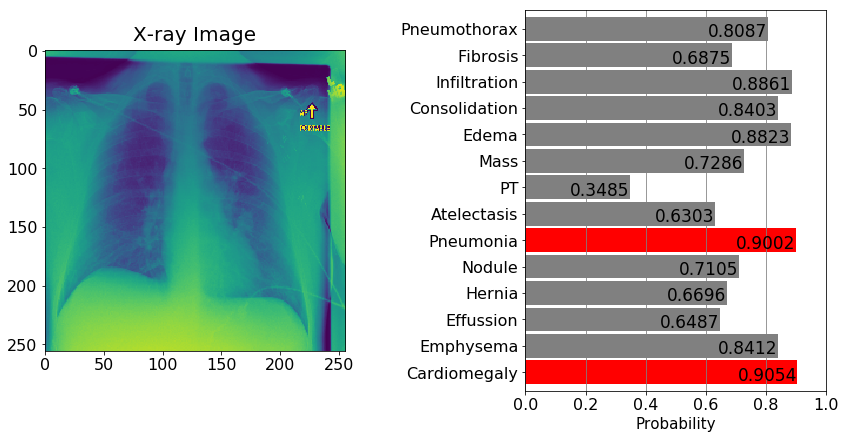

In [2]:
#Selected images

#image_file = os.environ.get('HOME') + '/notebooks/images_all/00030758_000.png'
image_file = os.environ.get('HOME') + '/notebooks/images_all/00030759_000.png'
#image_file = os.environ.get('HOME') + '/notebooks/images_all/00030768_000.png'
#image_file = os.environ.get('HOME') + '/notebooks/images_all/00030753_009.png'
#image_file = os.environ.get('HOME') + '/notebooks/images_all/00030758_000.png'
#image_file = os.environ.get('HOME') + '/notebooks/images_all/00029903_000.png'

#Pick a random image
image_file = os.environ.get('HOME') + '/notebooks/images_all/' + random.choice(os.listdir(os.environ.get('HOME') + '/notebooks/images_all/'))

proto_buf = './resnet50_chexnet_frozen_graph.pb'
ChexNet = ChexNet_Model(image_file=image_file, proto_buf=proto_buf, probability_threshold=0.9)
result = ChexNet.inference()